### Objective: To arrange data from new training 

In the past several months, the excellent biochemist/biophysicist on our team have been characterizing more and more internal antibody variants. I downloaded all the projects for which Heparin binding had been measured, folded them using AbodyBuilder 2 model and computed electrostatic surface features using my pipeline. I unfortunately did not save the features, I need recalculate the final descriptors. 

In this notebook, I am doing the following: 
1. Extracting the final features for all the antibodies that I have done the previous count. 
2. Looking at the data for antibodies that I downloaded. 
3. Normalizing the RTT times using a scaling factor provided by Joseph? 
4. Deciding on a hold out set (one particular antibody) for final evaluation.  


#### Load some packages. 

In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt 
from tqdm import tqdm
from itables import show
from sklearn.preprocessing import StandardScaler
from datetime import datetime

from developability.utils import ls
from developability import data as data_
from developability.antibody_structure import renumber_pdb, predict_antibody_structures
from developability.pipeline import run_processing_pipeline
from developability.utils import (extract_sequence_from_pdb,
                                  determine_chain_type
                                  )
from developability.descriptors import descriptor_pipeline




%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
data_path = Path(data_.__path__[0])
ls(data_path)

[PosixPath('/home/crivera/projects/developability/developability/data/pdbs'),
 PosixPath('/home/crivera/projects/developability/developability/data/experimental_data'),
 PosixPath('/home/crivera/projects/developability/developability/data/__pycache__'),
 PosixPath('/home/crivera/projects/developability/developability/data/__init__.py'),
 PosixPath('/home/crivera/projects/developability/developability/data/processed')]

In [3]:
pdbs_path = data_path/'pdbs'
experimental_data = data_path/'experimental_data'
antibody_df = pd.read_csv(experimental_data/'AntibodySequences.csv')

### Clean up the sequences. 
I recently noted that Antibody Builder2 failed to fold some sequences because they contained an "*". I also noted that some of the sequences were duplicated. 

In [4]:
number_with_asterisk = antibody_df['VH'].apply(lambda x: '*' in x).sum()
antibody_df['VH'] = antibody_df['VH'].apply(lambda x: x[:-1])
number_with_asterisk_after_pruning = antibody_df['VH'].apply(lambda x: '*' in x).sum()

print(f'Initially {number_with_asterisk} of the VH sequences had an * at the end, after pruning {number_with_asterisk_after_pruning} had it. ')

Initially 289 of the VH sequences had an * at the end, after pruning 0 had it. 


### Deduplicate Antibodies.
I meant to fold all the antibodies in the file (prededuplication). I expected ~1000, however, only about 632 antibodies were folded. This is less than the actual 832. (I'm not sure how I duplicated the antibodies).

Deduplicate first by all columns and then by sequences after counting. 

In [5]:
initial_counts = antibody_df['Project'].value_counts()
antibody_df = antibody_df.drop_duplicates()
intermediate_counts = antibody_df['Project'].value_counts()



In [6]:
combined_sequence = antibody_df['VH'] +'_'+ antibody_df['VL']

names_per_seq = {}
num_names_per_seq ={}

for name, cs in zip(antibody_df['Name'], combined_sequence):
    names_per_seq.setdefault(cs, []).append(name)
    num_names_per_seq.setdefault(cs, 0)
    num_names_per_seq[cs]+=1


num_names_per_seq=pd.Series(num_names_per_seq)
num_names_per_seq.value_counts().sort_index()

1     785
2       8
3       8
4       1
5       1
6       1
12      1
Name: count, dtype: int64

### Get the sequences with multiple names. 

In [7]:
seqs_with_multiple_names = num_names_per_seq.loc[num_names_per_seq>1].index.to_list()
seqs_with_multiple_names = {seq:names_per_seq[seq] for seq in seqs_with_multiple_names}

for val in seqs_with_multiple_names.values():
    print(val)

['VIRMAB-FNI9-R1-1', 'VIRMAB-FNI9-R1-2', 'VIRMAB-RSD5-R1-3', 'VIRMAB-MPK201-R1-3', 'VIRMAB-MPK65-R1-3']
['VIRMAB-RSD5-R1-5', 'VIRMAB-MPK201-R1-5', 'VIRMAB-MPK65-R1-5', 'VIRMAB-ML-M190-R2-084', 'VIRMAB-MPK176-R1-1', 'VIRMAB-MPK176-R1-2']
['VIRMAB-RSD5-R1-4', 'VIRMAB-MPK201-R1-4', 'VIRMAB-ML-P38-96', 'VIRMAB-MPK65-R1-4', 'VIRMAB-ML-M190-R2-150', 'VIRMAB-ML-M190-R2-150', 'VIRMAB-ML-M190-R2-150', 'VIRMAB-ML-M190-R2-151', 'VIRMAB-ML-M190-R2-151', 'VIRMAB-ML-M190-R2-086', 'VIRMAB-ML-M190-R2-085', 'VIRMAB-MPK176-R1-4']
['VIRMAB-MPK201-R1-6', 'VIRMAB-MPK65-R1-6', 'VIRMAB-MPK176-R1-133']
['VIRMAB-MPK201-R1-1', 'VIRMAB-MPK201-R1-2']
['VIRMAB-ML-P38-91', 'VIRMAB-ML-P38-14']
['VIRMAB-ML-P38-1', 'VIRMAB-ML-P38-94']
['VIRMAB-MPK65-R1-1', 'VIRMAB-MPK65-R1-2']
['VIRMAB-ML-M190-R2-059', 'VIRMAB-ML-M190-R2-059', 'VIRMAB-ML-M190-R2-059']
['VIRMAB-ML-M190-R2-066', 'VIRMAB-ML-M190-R2-066', 'VIRMAB-ML-M190-R2-066']
['MPK190-V43.29', 'VIRMAB-ML-M190-R2-048']
['MPK190-V38.23', 'VIRMAB-ML-M190-R2-140', 'VIRMAB

### Identify which names have a pdb associated with them 

In [8]:
pdbs = [file for file in ls(pdbs_path) if file.is_file() and file.name.endswith('.pdb') and (pdbs_path/f"{file.stem}_outputs").exists()]
pdb_names = pd.Series([f.stem for f in pdbs])
pdb_names.sort_values()
pdb_names

0       VIRMAB-MPK65-R1-71
1      VIRMAB-MPK201-R1-48
2            MPK190-V49.23
3       VIRMAB-MPK65-R1-63
4      VIRMAB-MPK201-R1-81
              ...         
825     VIRMAB-RSD5-R1-136
826      VIRMAB-RSD5-R1-93
827       VIRMAB-ML-P38-89
828       VIRMAB-RSD5-R1-5
829    VIRMAB-MPK176-R1-84
Length: 830, dtype: object

In [9]:
antibody_df['is_folded'] = antibody_df['Name'].isin(pdb_names)
antibody_df = antibody_df.sort_values(['is_folded'], ascending = False)
antibody_df['is_folded'].sum()

850

### Now drop duplicates based on the sequence. 

In [10]:
antibody_df2 = antibody_df.drop_duplicates(subset = ['VH', 'VL'])
final_counts = antibody_df2['Project'].value_counts()

counts = pd.concat([initial_counts, intermediate_counts, final_counts], axis = 1)
counts.columns = ['Initial', 'Intermediate', 'Final']
counts

,Initial,Intermediate,Final
Project,,,
MPK190,350,210,182
RSD5,149,130,127
MPK176,142,134,131
MPK65,138,135,132
MPK201,136,135,130
PIA38,89,89,86
FNI9v81,19,19,17


### Visual evidence that dedup occured as desired. 

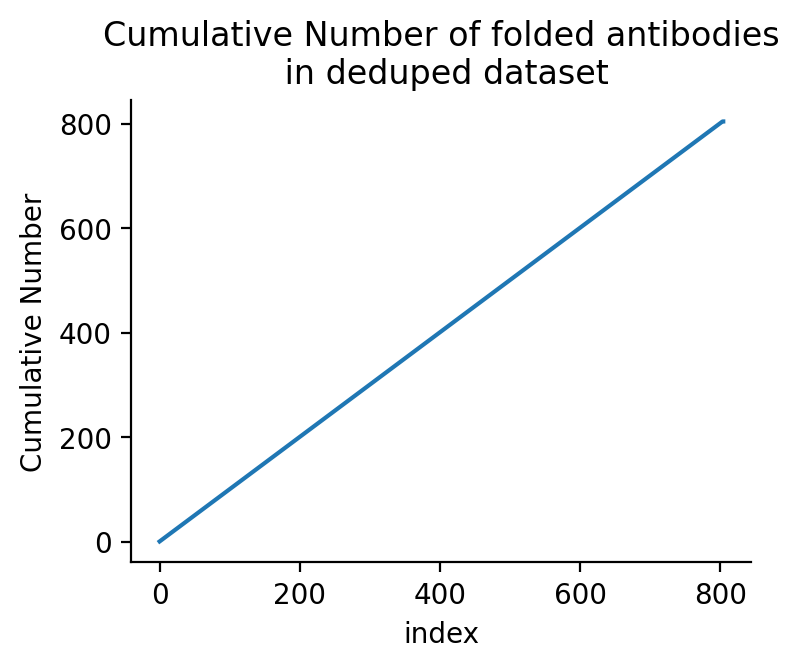

In [11]:
ax = antibody_df2['is_folded'].reset_index(drop=True).cumsum().plot(figsize =(4,3))
ax.set(xlabel ='index', ylabel = 'Cumulative Number', title='Cumulative Number of folded antibodies\n in deduped dataset')
sns.despine()

### Plot the number per project after all dedupes

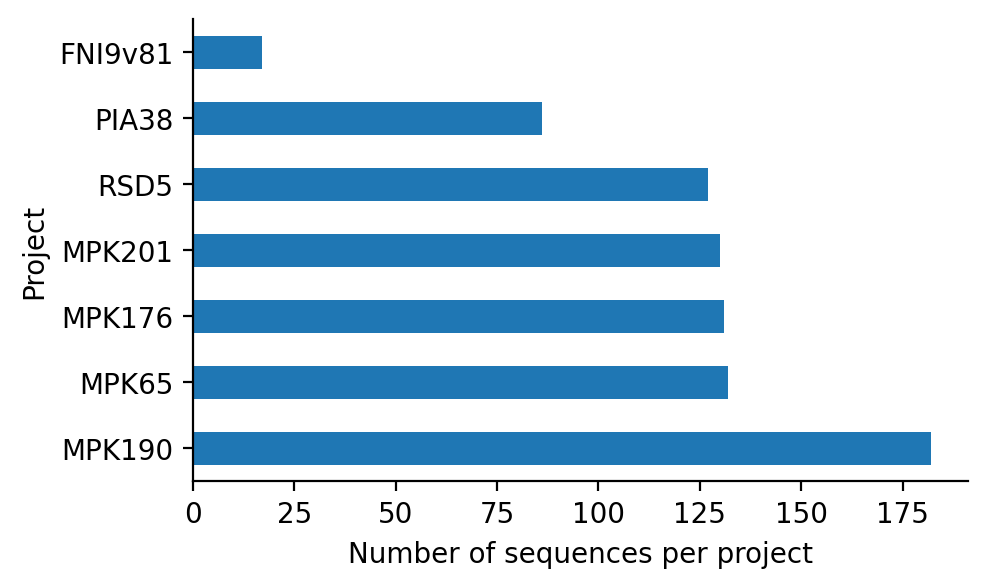

In [12]:
ax = antibody_df2['Project'].value_counts().plot(kind='barh', figsize = (5, 3))
ax.set(xlabel = 'Number of sequences per project')
sns.despine()

### Distribution of heparin RTT

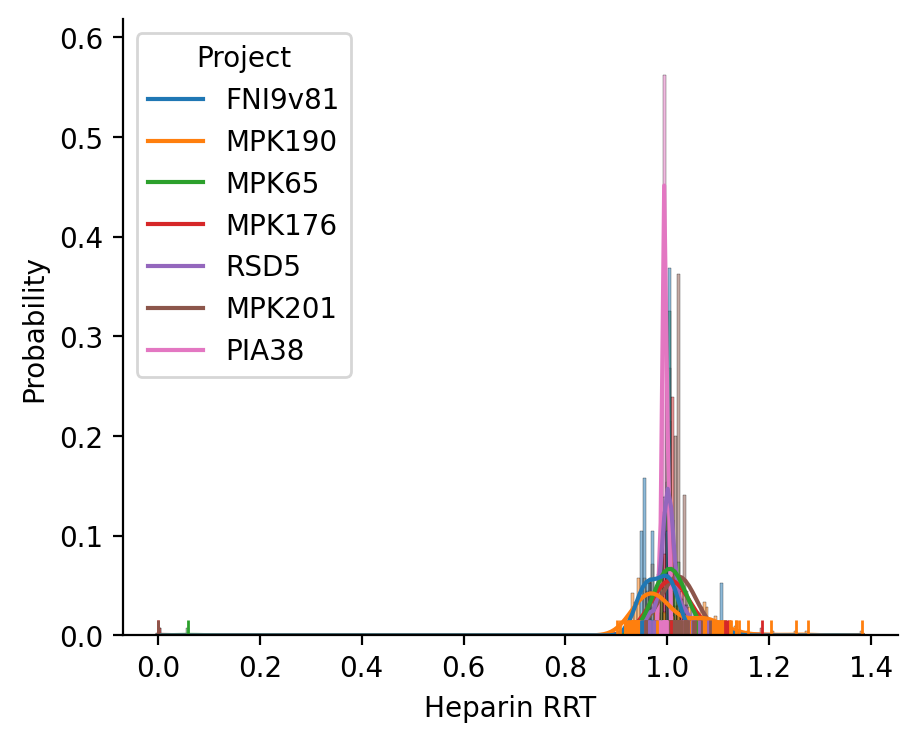

In [13]:
fig, ax = plt.subplots(1,1, figsize = (5,4))
ax = sns.histplot(data = antibody_df, x = 'Heparin RRT', hue='Project', common_norm=False, kde=True, stat='probability')
sns.rugplot(data = antibody_df, x = 'Heparin RRT', hue='Project')
sns.despine()


### Get the antibody sequences that were previously unfolded and fold them. 

In [14]:
not_folded  = antibody_df2.loc[antibody_df2['is_folded']==False]
len(not_folded)

1

### Try to fold them again. 

errors = predict_antibody_structures(not_folded, output_dir = pdbs_path)

#### Could not fold 
'VIRMAB-ML-M190-R2-081'

### Renumber 

In [15]:
pdbs_to_renumber = [file for file in ls(pdbs_path) if file.is_file() and file.name.endswith('.pdb') and not (pdbs_path/f"{file.stem}_outputs").exists()]
_ = [renumber_pdb(pdb, pdb) for pdb  in tqdm( pdbs_to_renumber, total = len(pdbs_to_renumber))]

0it [00:00, ?it/s]


### Compute the descriptors for these. 

In [16]:
_ = [run_processing_pipeline(pdb) for pdb in tqdm(pdbs_to_renumber, total=len(pdbs_to_renumber))]

0it [00:00, ?it/s]


### Refetch the pdbs with outputs.

Note that I performed duplicate calculations on some of the duplicated sequences. 

In [17]:
pdbs = [file for file in ls(pdbs_path) if file.is_file() and file.name.endswith('.pdb') and (pdbs_path/f"{file.stem}_outputs").exists()]
len(pdbs),len(antibody_df2)

(830, 805)

### Re-extract the descriptors. 
I did not did not save the descriptors, so I need to do this again. 

In [18]:
def extract_descriptors(input_pdb):
    # get the sequence from the input pdb
    sequences = extract_sequence_from_pdb(input_pdb)
    light_chain_seq, heavy_chain_seq = determine_chain_type(sequences)

    # Calculate the descriptors
    antibody_name = input_pdb.stem
    output_path = pdbs_path/f'{input_pdb.stem}_outputs'
    residue_pot_file = output_path/'residue_potential.csv'
    descriptors = descriptor_pipeline(
        light_chain_seq, heavy_chain_seq, residue_pot_file, antibody_name)

    # clean out logs in execution location

    return descriptors

In [19]:
today = '04-26-2024'
descriptors_filename = data_path/f'processed/descriptors_for_internal_antibodies_predicted_{today}.parquet'
if not descriptors_filename.exists():

    descriptors = pd.concat([extract_descriptors(f) for f in tqdm(pdbs, total=len(pdbs))])
    descriptors.to_parquet(descriptors_filename)
else: 
    descriptors = pd.read_parquet(descriptors_filename)


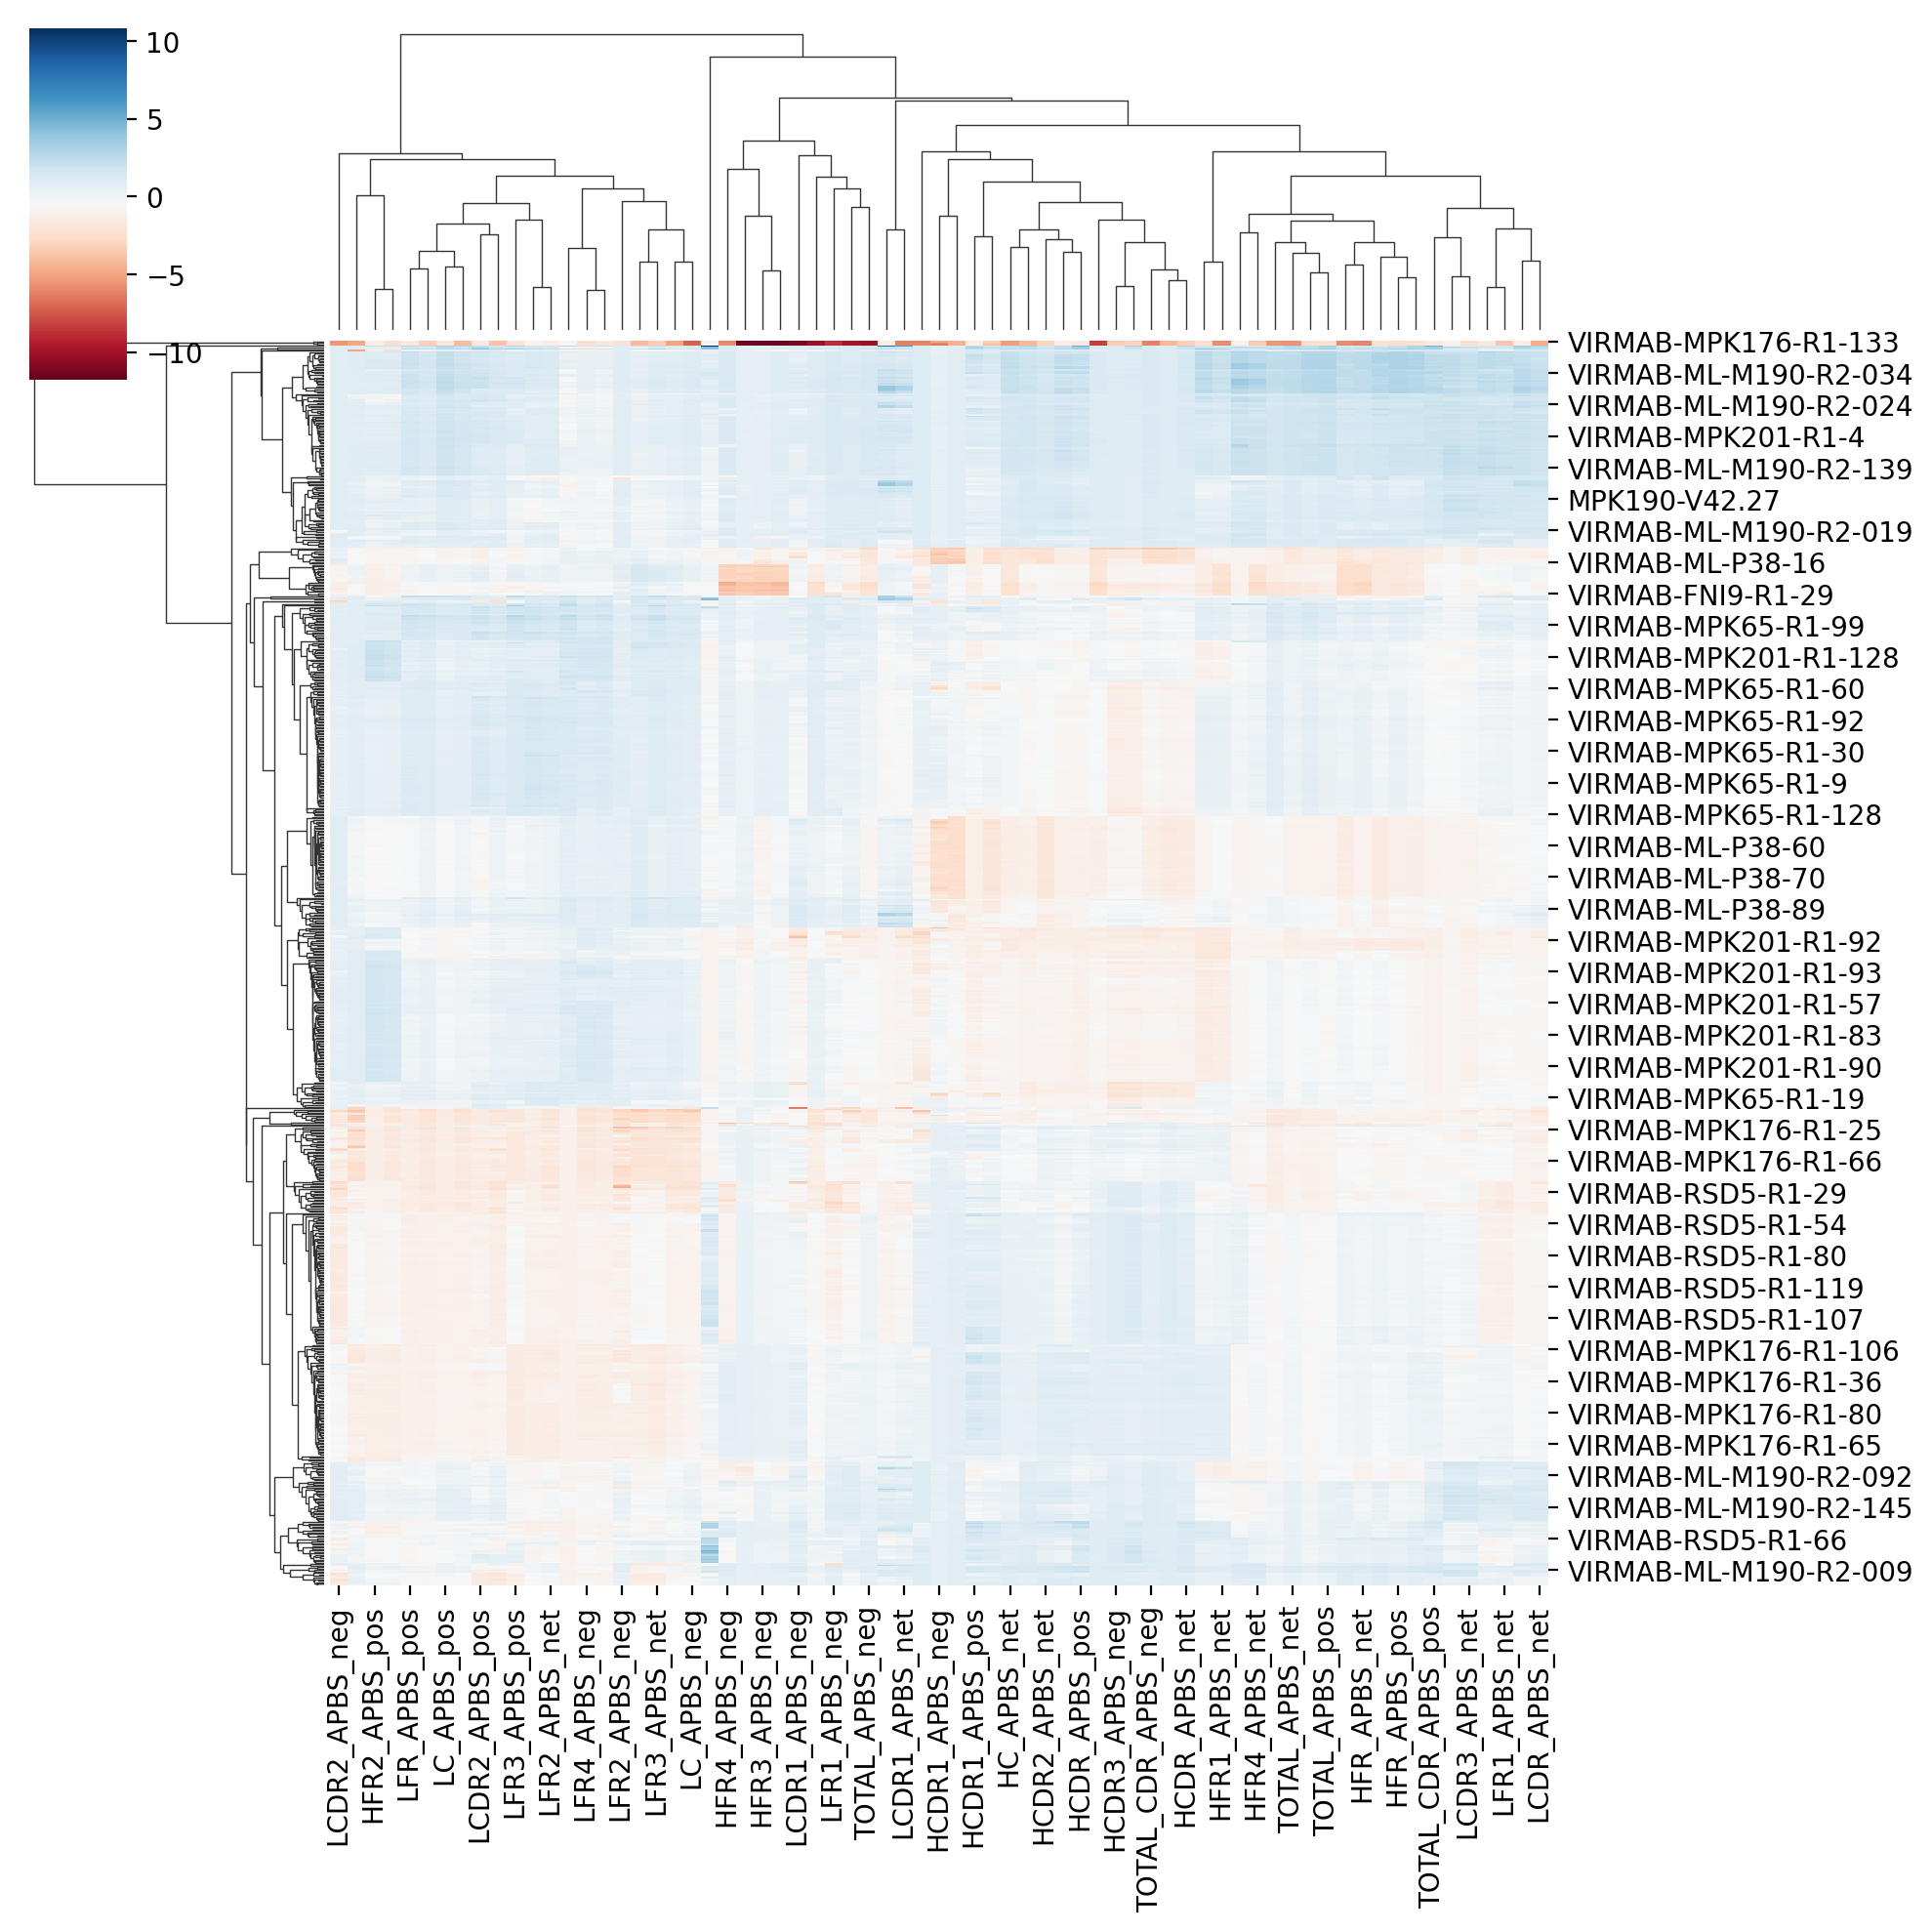

In [20]:
descriptors_scaled = StandardScaler().fit_transform(descriptors)
descriptors_scaled = pd.DataFrame(descriptors_scaled, columns = descriptors.columns, index = descriptors.index)

sns.clustermap(descriptors_scaled, cmap='RdBu', figsize = (10,10))



In [21]:
descriptors_filename

PosixPath('/home/crivera/projects/developability/developability/data/processed/descriptors_for_internal_antibodies_predicted_04-26-2024.parquet')